In [1]:
from pyrates.utility import plot_timeseries, grid_search, plot_psd, plot_connectivity, create_cmap
from pyrates.frontend import CircuitTemplate
from pyrates.backend import ComputeGraph
import numpy as np
import matplotlib.pyplot as plt

Excitatory-Inhibitory Circuit: Documentation of the model configuration and state space exploration
===================

In this notebook, I define the basic EI circuit that I will use later on to build a cortical microcircuit model.
I will lay out the model definition first and then investigate the model dynamics for different parametrizations.

I: Model configuration
--------------------------------

The model described here is a simple neural population model consisting of an excitatory and an inhibitory neural population. As shown below, the populations express both intra-population coupling and bi-directional inter-population coupling.

-include image-

Each population is represented by an extended Montbrio model (Montbrio et al. 2015). The Montbrio model is a mathematically exact mean-field description of the macroscopic state of a globally coupled quadratic integrate-and-fire population. The dynamics of its average membrane potential $v$ and average firing rate $r$ follow:

$$\dot{r} = \frac{\Delta}{\pi \tau^2} + \frac{2 r v}{\tau}$$

$$\dot{v} = \frac{v^2 + \overline{\eta} + J r + I(t)}{\tau} - \tau \pi^2 r^2$$

Where $\tau$ is the lumped time-constant of the membrane, $J$ is a coupling constant, $I$ is an extrinsic input current and $\overline{\eta}$ and $\Delta$ are parameters of a Lorentzian probability distribution describing the distribution of firing thresholds in the neural population. This model is extended by synaptic response dynamics. In particular, each population has an inhibitory and an excitatory synapse that formulate a convolution of synaptic input $r_{e/i}$ with an alpha kernel:

$$\dot{v_{e/i}} =  \frac{H_{e/i}}{\tau_{e/i}} r_{e/i} - \frac{v_{e/i}}{\tau_{e/i}^2} - \frac{2 I_{e/i}}{\tau_{e/i}}$$

$$\dot{I_{e/i}} = v_{e/i}$$

where the subscripts $e$ and $i$ mark whether the synapse is excitatory or inhibitory. This convolution models the dynamics of the synaptic input current $I_{e/i}$ as an exponential rise and decay with a single time-constant $\tau_{e/i}$ and a synaptic efficacy $H_{e/i}$. 
Finally, a short-term plasticity mechanism is added to the model, to account for experimentally observed saturations of firing rate responses to constant input (include citation). This short-term plasticity is defined over the mean of the distribution of firing thresholds $\overline{\eta}$:

$$\dot{\overline{\eta}} = \frac{\eta_0 - \overline{\eta} - \alpha r}{\tau_{\eta}}$$

Which describes an exponential attraction of $\overline{\eta}$ to the resting threshold mean $\eta_0$ with a time-constant $\tau_{\eta}$.
This leads to the following set of coupled differential equations that define the dynamics of a single, excitatory neural population:

$$\dot{r} = \frac{\Delta}{\pi \tau^2} + \frac{2 r v}{\tau}$$

$$\dot{\overline{\eta}} = \frac{\eta_0 - \overline{\eta} - \alpha r}{\tau_{\eta}}$$

$$\dot{v} = \frac{v^2 + \overline{\eta} + I(t)}{\tau} - \tau \pi^2 r^2$$

With I(t) being defined as follows:

$$I(t) = I_e - I_i + I_{ext}$$

$$\dot{v_{e}} =  \frac{H_{e}}{\tau_{e}} (r_{e} + J r) - \frac{v_{e}}{\tau_{e}^2} - \frac{2 I_{e}}{\tau_{e}}$$

$$\dot{I_{e}} = v_{e}$$

$$\dot{v_{i}} =  \frac{H_{i}}{\tau_{i}} r_{i} - \frac{v_{i}}{\tau_{i}^2} - \frac{2 I_{i}}{\tau_{i}}$$

$$\dot{I_{i}} = v_{i}$$

where $I_{ext}$ is an extrinsic input current. To model an inhibitory population, the term $J r$ simply needs to be transferred from the excitatory synapse to the inhibitory synapse.
Based on the the parametrizations used in Jansen \& Rit (1995) and Montbrio et al. (2015), I used the following initial set of parameters:

$\tau = 0.02 s$

$J = 15.0$

$\Delta = 1.0$

$\eta_0 = -5.0$

$\tau_{\eta} = 0.1$

$\alpha = 0.05$

$\tau_e = 0.01 s$

$\tau_i = 0.02 s$

$H_e = 3.25 nA$

$H_i = 22.0 nA$

II: Dynamics of the basic montbrio model for the standard parametrization
----------------------------------------------------------------------------------------------------------

Below, we show the membrane potential and firing rate dynamics for constant and oscillatory extrinsic input applied to a single base Montbrio population (without any extensions). This is done separately for an excitatory and an inhibitory population.

**Parameter definition:**

In [2]:
dt = 1e-4
T = 4.
mu = 3.
input_start = int(1./dt)
input_end = int(3./dt)
input_constant = np.zeros((int(T/dt), 1))
input_constant[input_start:input_end] = mu
input_oscillatory = np.zeros_like(input_constant)
input_oscillatory[input_start:input_end, 0] = 3. * np.sin(np.pi * np.arange(input_start * dt, input_end * dt, dt))

**Model definition:**

In [5]:
# define the models via a yaml template
net_config = CircuitTemplate.from_yaml("../config/cmc_templates.EI_base").apply()

# load the template into a compute graph
net = ComputeGraph(net_config, vectorization='full', dt=1e-4)

**Simulations:**

In [9]:
results_const = net.run(T, inputs={("E", "Op_e_base.0", "i_in"): input_constant,
                                   ("I", "Op_i_base.0", "i_in"): input_constant}, 
                        outputs={"r_e": ("E", "Op_e_base.0", "r"),
                                 "r_i": ("I", "Op_i_base.0", "r")},
                        sampling_step_size=1e-3)

results_oscil = net.run(T, inputs={("E", "Op_e_base.0", "i_in"): input_oscillatory,
                                   ("I", "Op_i_base.0", "i_in"): input_oscillatory}, 
                        outputs={"r_e": ("E", "Op_e_base.0", "r"),
                                 "r_i": ("I", "Op_i_base.0", "r")},
                        sampling_step_size=1e-3)

**Visualization:**

Text(0.5, 1.0, 'I: oscillatory')

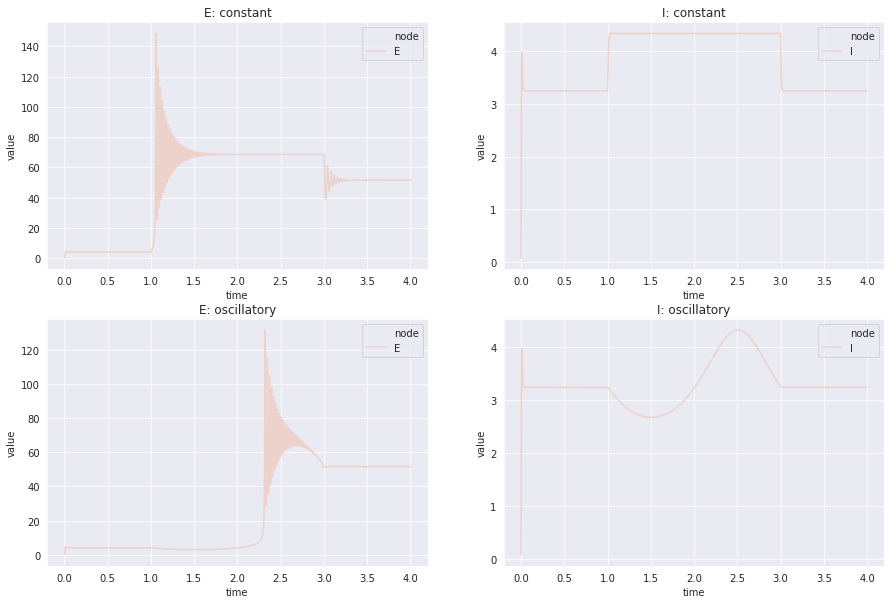

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes[0, 0] = plot_timeseries(results_const['r_e'], ax=axes[0, 0])
axes[0, 0].set_title('E: constant')
axes[0, 1] = plot_timeseries(results_const['r_i'], ax=axes[0, 1])
axes[0, 1].set_title('I: constant')
axes[1, 0] = plot_timeseries(results_oscil['r_e'], ax=axes[1, 0])
axes[1, 0].set_title('E: oscillatory')
axes[1, 1] = plot_timeseries(results_oscil['r_i'], ax=axes[1, 1])
axes[1, 1].set_title('I: oscillatory')

III: Montbrio population parameter space exploration
-----------------------------------------------------------------------

In this section, we investigate the dynamic behavior of a single extended Montbrio population for different parametrizations.

**Parameter: $\eta$**

In [22]:
# parameter definition
eta = np.arange(-10., 11, 1.)
param_map = {'eta': {'var': [('Op_e_base.0', 'eta'), ('Op_i_base.0', 'eta')],
                     'nodes': ['E.0', 'I.0']}}

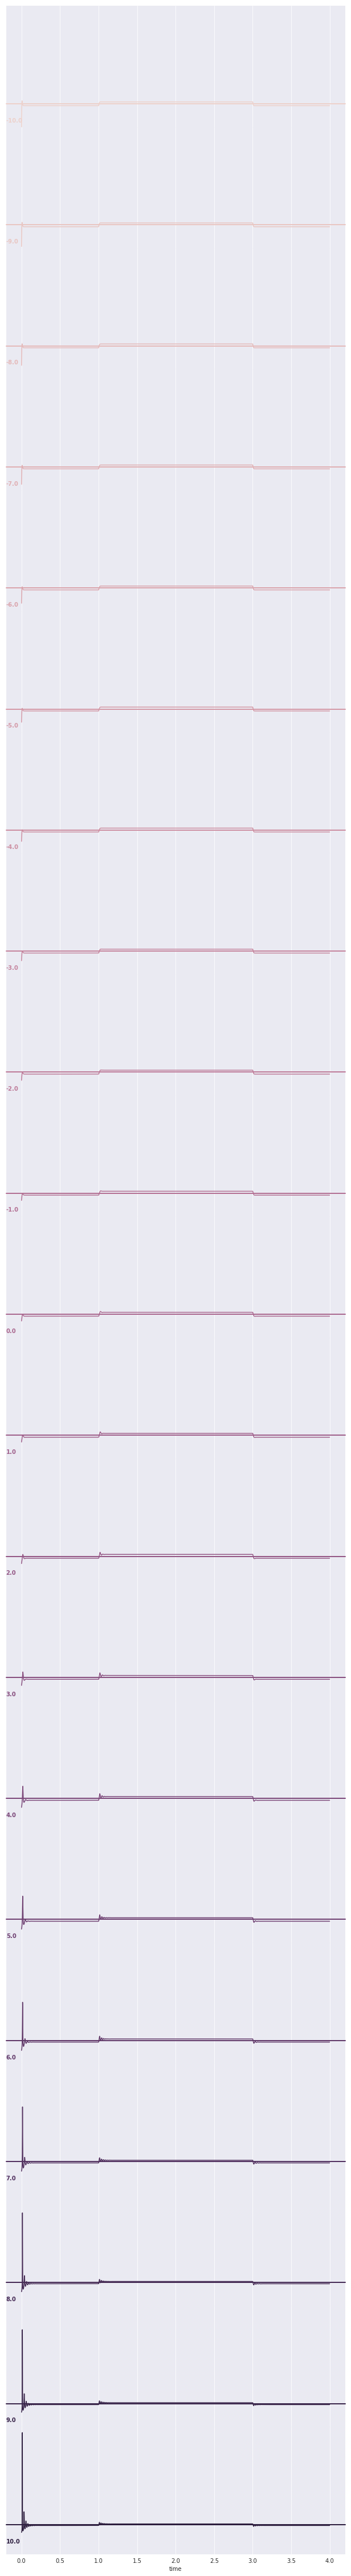

In [21]:
# simulate behavior for different etas
results = grid_search(circuit_template="../config/cmc_templates.EI_base",
                      param_grid={'eta': eta}, param_map=param_map,
                      inputs={("E", "Op_e_base.0", "i_in"): input_constant, 
                              ("I", "Op_i_base.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_base.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $\delta$**

In [ ]:
# parameter definition
delta = np.asarray([0.01, 0.02, 0.04, 0.08, 0.16, 0.32, 0.64, 1.28, 2.56, 5.12, 10.24])
param_map = {'delta': {'var': [('Op_e_base.0', 'delta'), ('Op_i_base.0', 'delta')],
                       'nodes': ['E.0', 'I.0']}}

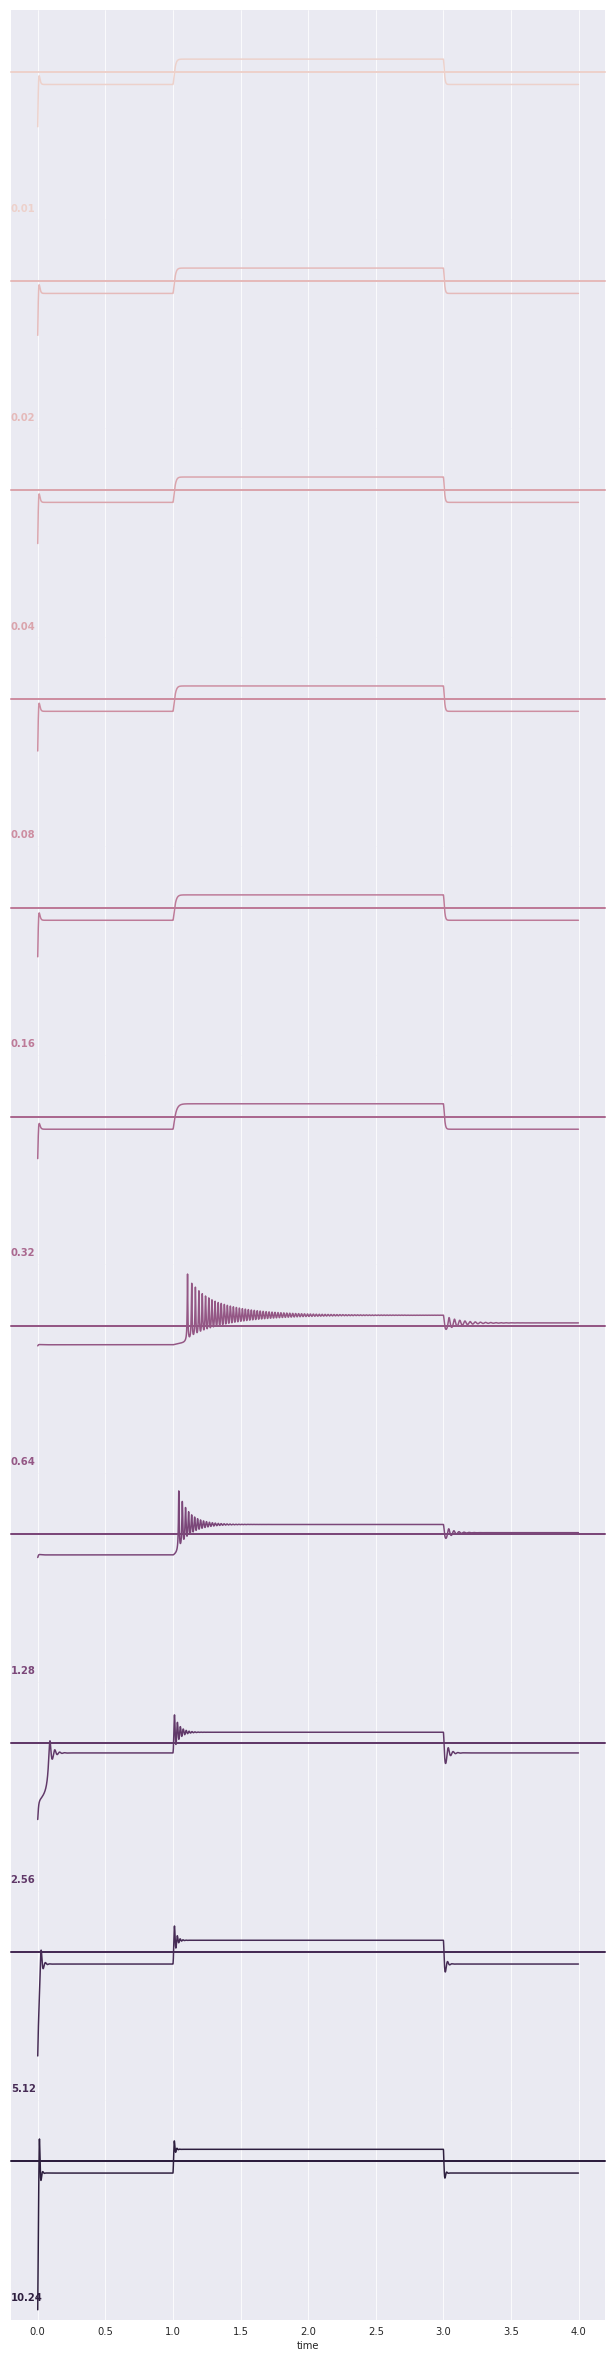

In [23]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI_base",
                      param_grid={'delta': delta}, param_map=param_map,
                      inputs={("E", "Op_e_base.0", "i_in"): input_constant, 
                              ("I", "Op_i_base.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_base.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $\tau$**

In [24]:
# parameter definition
tau = np.arange(0.01, 0.1, 0.01)
param_map = {'tau': {'var': [('Op_e_base.0', 'tau'), ('Op_i_base.0', 'tau')],
                     'nodes': ['E.0', 'I.0']}}

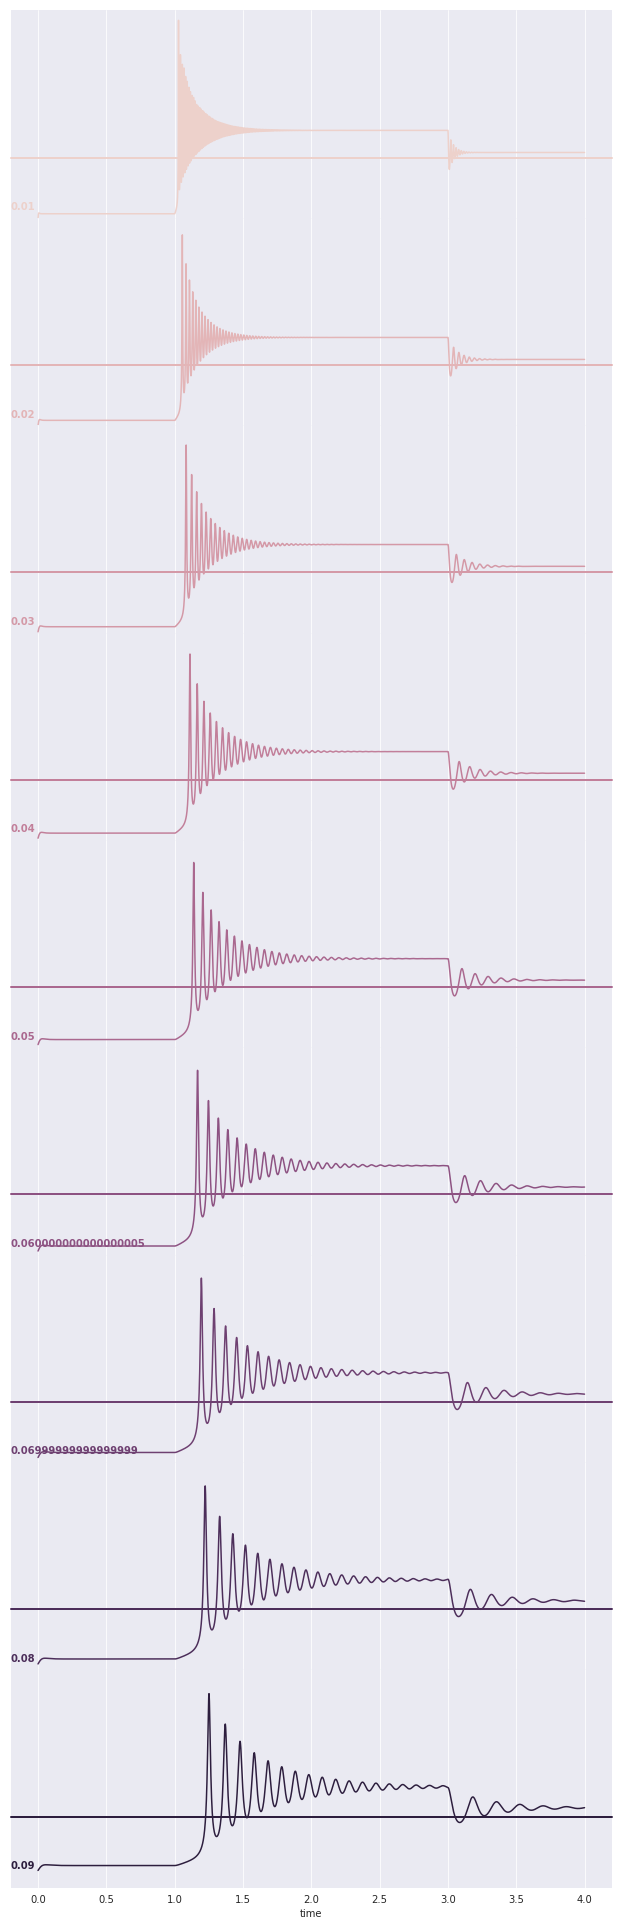

In [25]:
# simulate behavior for different taus
results = grid_search(circuit_template="../config/cmc_templates.EI_base",
                      param_grid={'tau': tau}, param_map=param_map,
                      inputs={("E", "Op_e_base.0", "i_in"): input_constant, 
                              ("I", "Op_i_base.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_base.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $J$**

In [27]:
# parameter definition
J = np.arange(1., 40., 2.)
param_map = {'J': {'var': [('Op_e_base.0', 'J'), ('Op_i_base.0', 'J')],
                   'nodes': ['E.0', 'I.0']}}

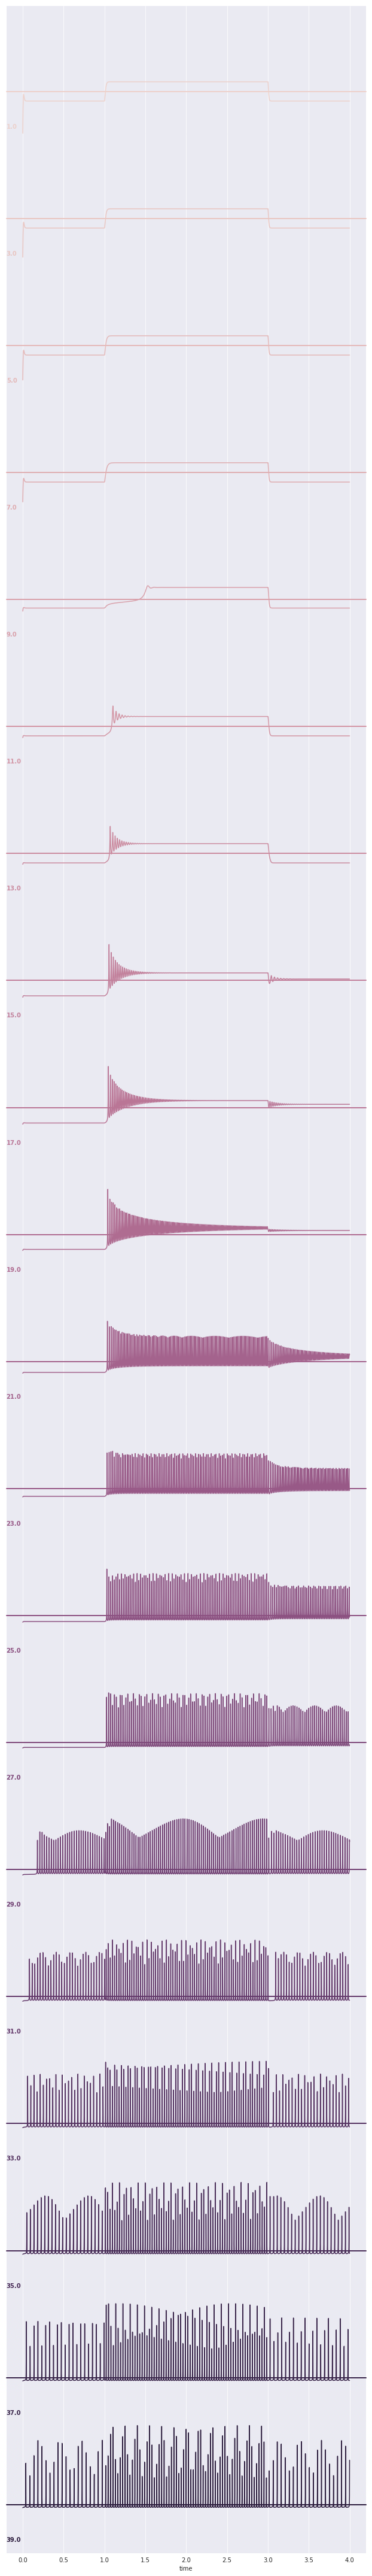

In [28]:
# simulate behavior for different Js
results = grid_search(circuit_template="../config/cmc_templates.EI_base",
                      param_grid={'J': J}, param_map=param_map,
                      inputs={("E", "Op_e_base.0", "i_in"): input_constant, 
                              ("I", "Op_i_base.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_base.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

IV: Analysis of the effects of short-term firing threshold adaptations
-------------------------------------------------------------------------------------------------

In this section, I investigate the effects and parameters of the above described
short-term plasticity mechanism on the Montbrio population dynamics.

**Parameter: $\eta_0$**

In [3]:
# parameter definition
eta_0 = np.arange(-10., 0., 1.)
param_map = {'eta_0': {'var': [('Op_e_adapt.0', 'eta_0'), ('Op_i_adapt.0', 'eta_0')],
                       'nodes': ['E.0', 'I.0']}}

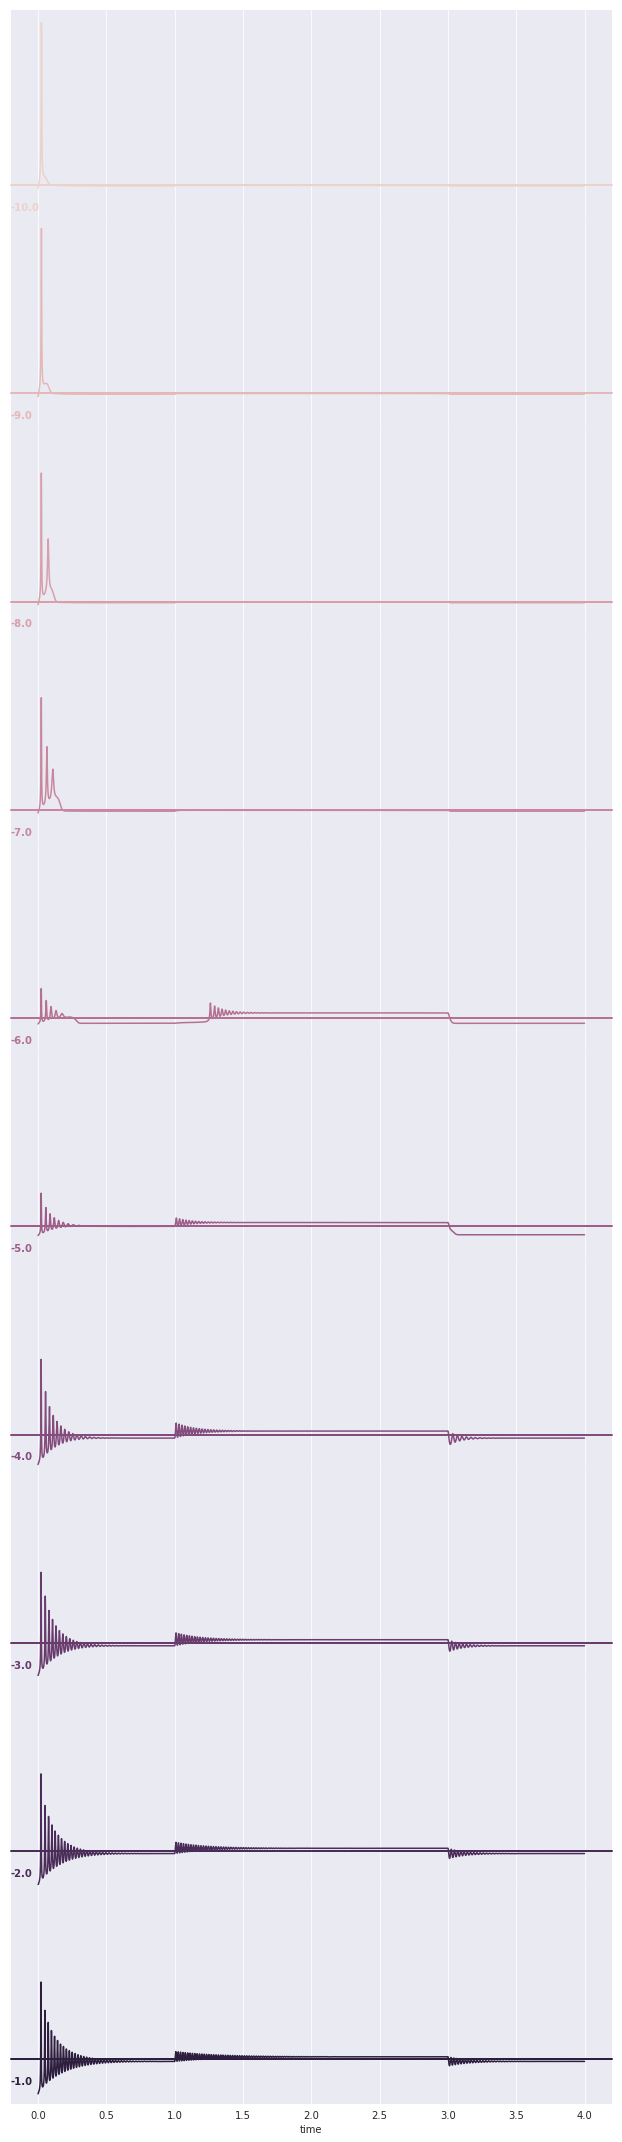

In [4]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'eta_0': eta_0}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $\alpha$**

In [14]:
# parameter definition
alpha = np.arange(0.001, 0.1, 0.005)
param_map = {'alpha': {'var': [('Op_e_adapt.0', 'alpha'), ('Op_i_adapt.0', 'alpha')],
                       'nodes': ['E.0', 'I.0']}}

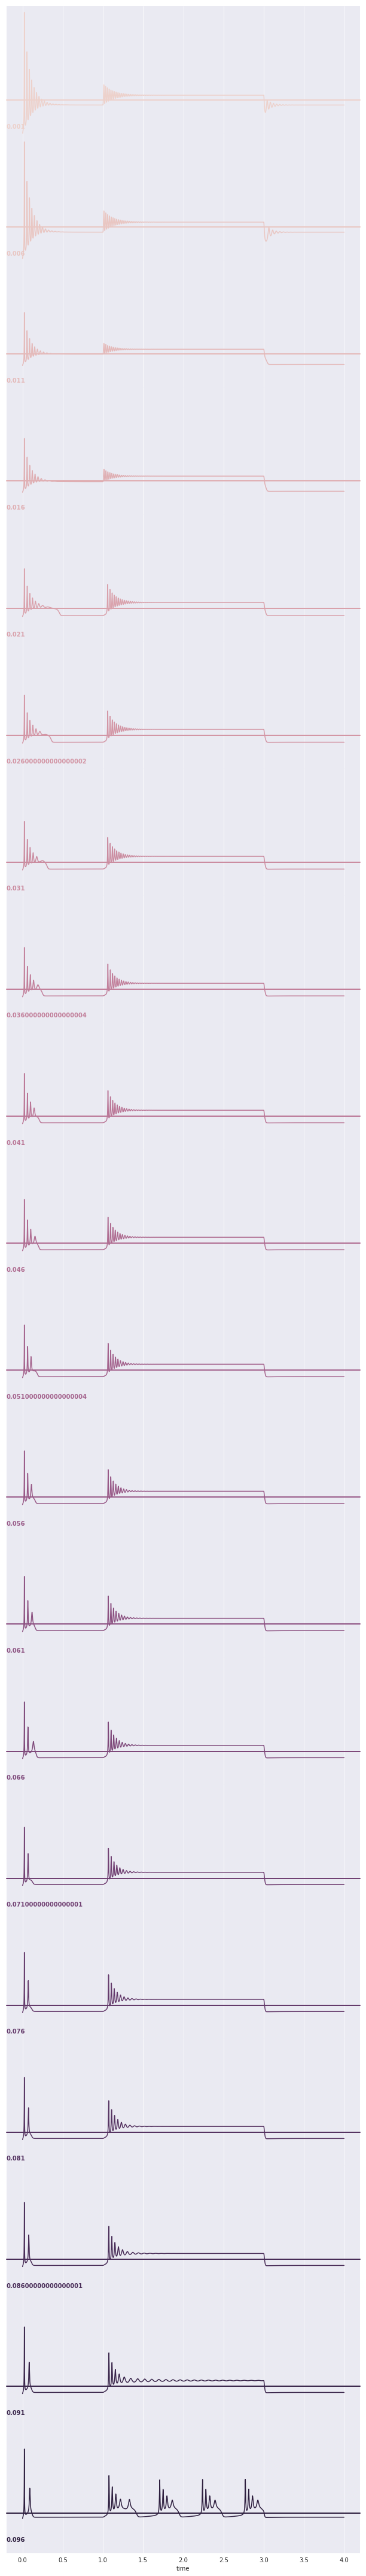

In [15]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI_adapt",
                      param_grid={'alpha': alpha}, param_map=param_map,
                      inputs={("E", "Op_e_adapt.0", "i_in"): input_constant, 
                              ("I", "Op_i_adapt.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_adapt.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

V: Analysis of the effects of synpatic responses on the Montbrio model
-----------------------------------------------------------------------------------------------------

In this section, we add an alpha-kernel as model of the synaptic response dynamics to the Montbrio model
and analyze its effects on the model dynamics

**Parameter: $\tau_{e/i}$**

In [9]:
# parameter definition
tau = np.arange(0.001, 0.015, 0.001)
param_map = {'tau': {'var': [('Op_e_syn.0', 'tau_e'), ('Op_i_syn.0', 'tau_i')],
                     'nodes': ['E.0', 'I.0']}}

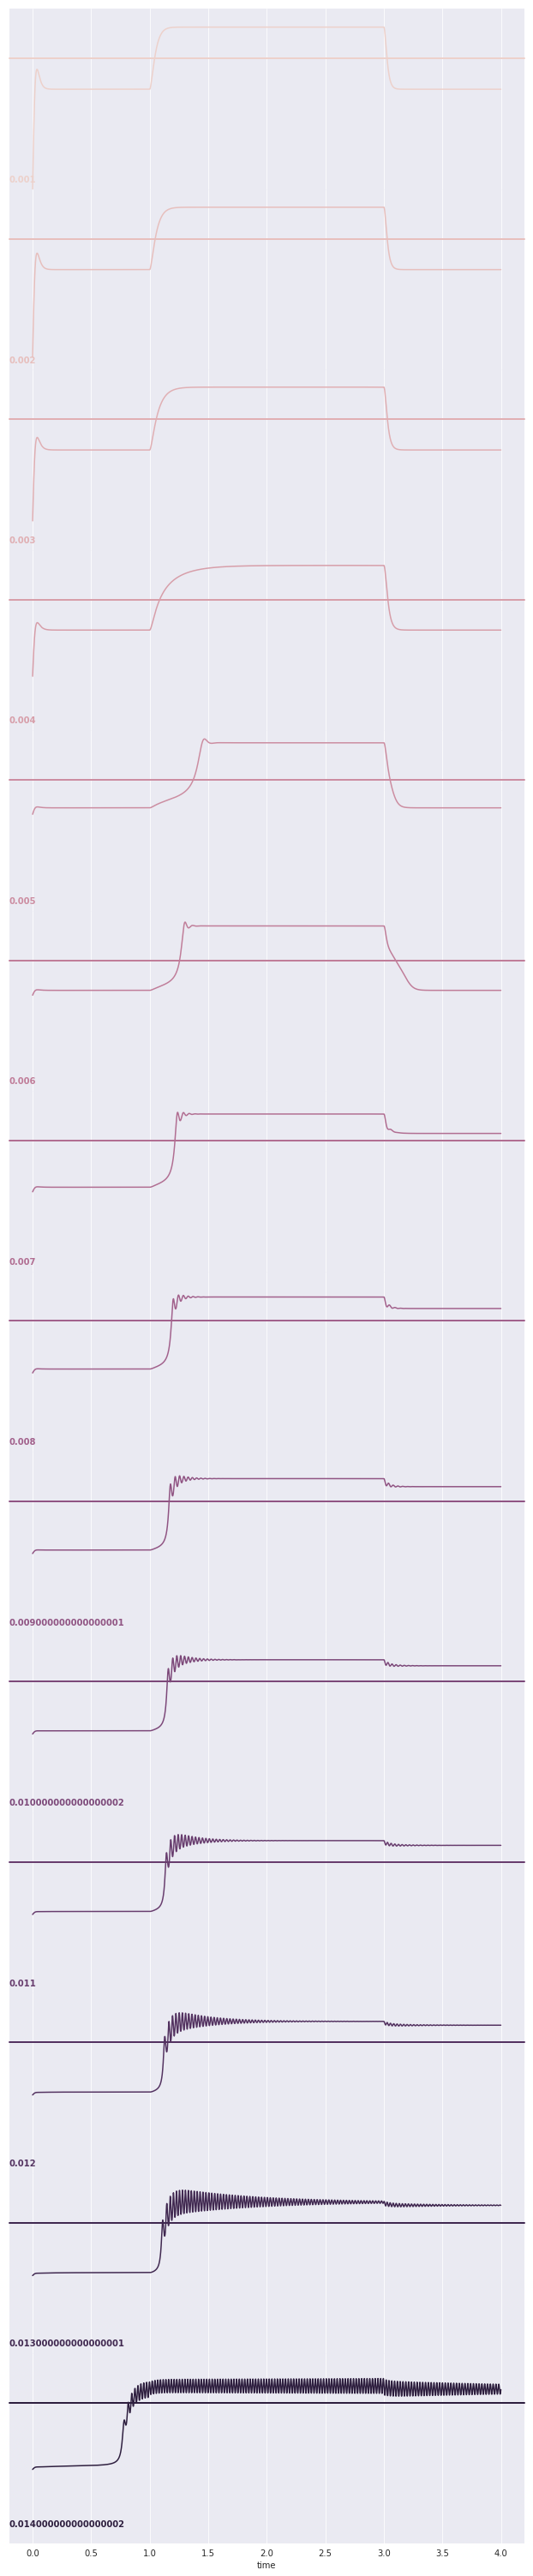

In [10]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI_syn",
                      param_grid={'tau': tau}, param_map=param_map,
                      inputs={("E", "Op_e_syn.0", "i_in"): input_constant, 
                              ("I", "Op_i_syn.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_syn.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $H_e$**

In [11]:
# parameter definition
H = np.arange(1., 16.)
param_map = {'H': {'var': [('Op_e_syn.0', 'H_e'), ('Op_i_syn.0', 'H_i')],
                   'nodes': ['E.0', 'I.0']}}

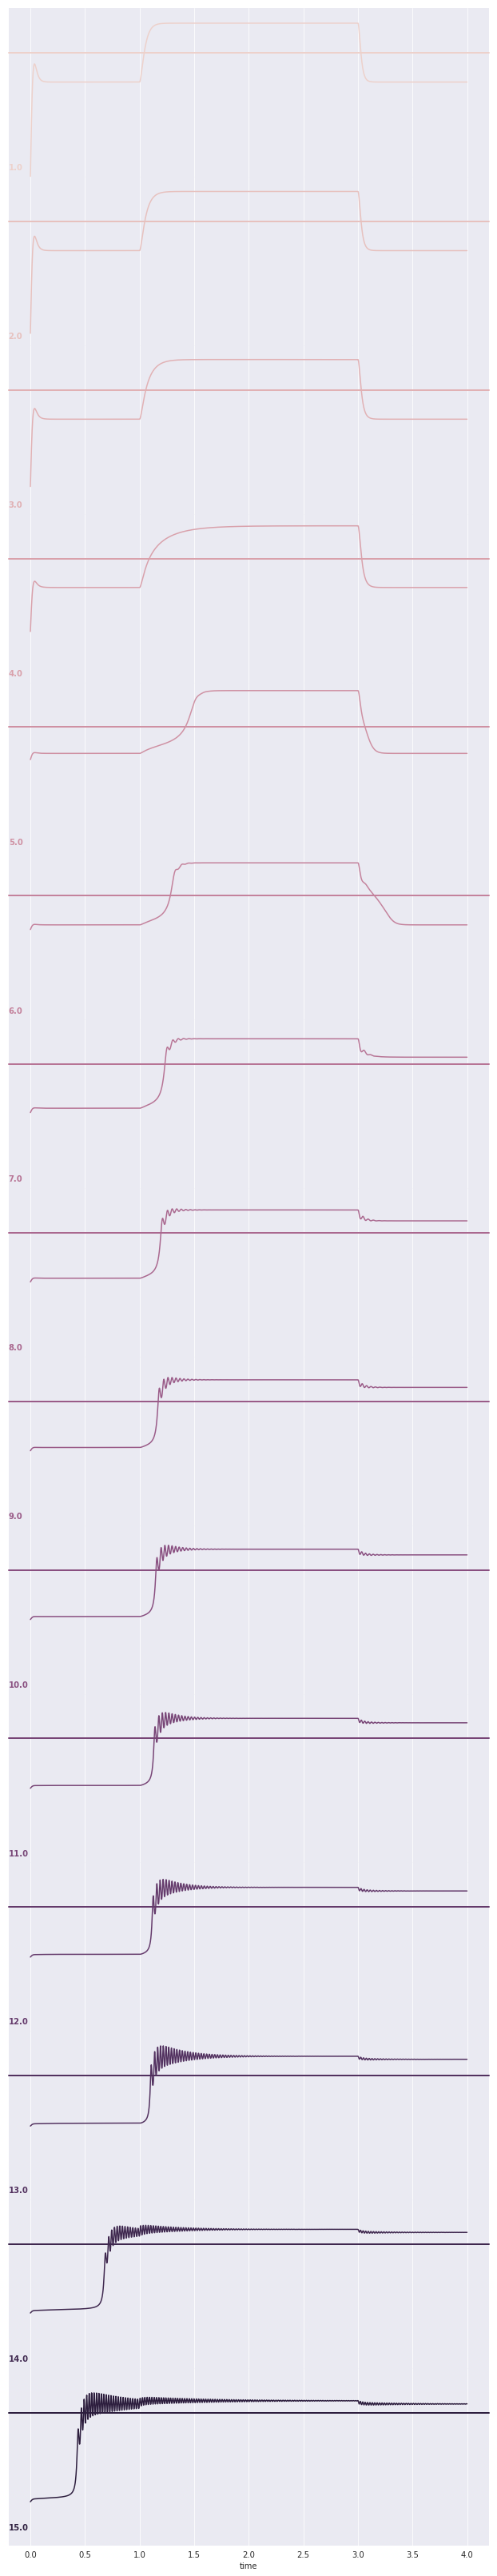

In [12]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI_syn",
                      param_grid={'H': H}, param_map=param_map,
                      inputs={("E", "Op_e_syn.0", "i_in"): input_constant, 
                              ("I", "Op_i_syn.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e_syn.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

VI: Analysis of the effect of adding short-term plasticity and synaptic response dynamics to the Montbrio model
----------------------------

In this section, we combine the mechanisms of section IV and V and investigate their effects on the Montbrio model.

**Parameter: $\eta_0$**

In [5]:
# parameter definition
eta_0 = np.arange(-10., 10., 1.)
param_map = {'eta_0': {'var': [('Op_e.0', 'eta_0'), ('Op_i.0', 'eta_0')],
                       'nodes': ['E.0', 'I.0']}}

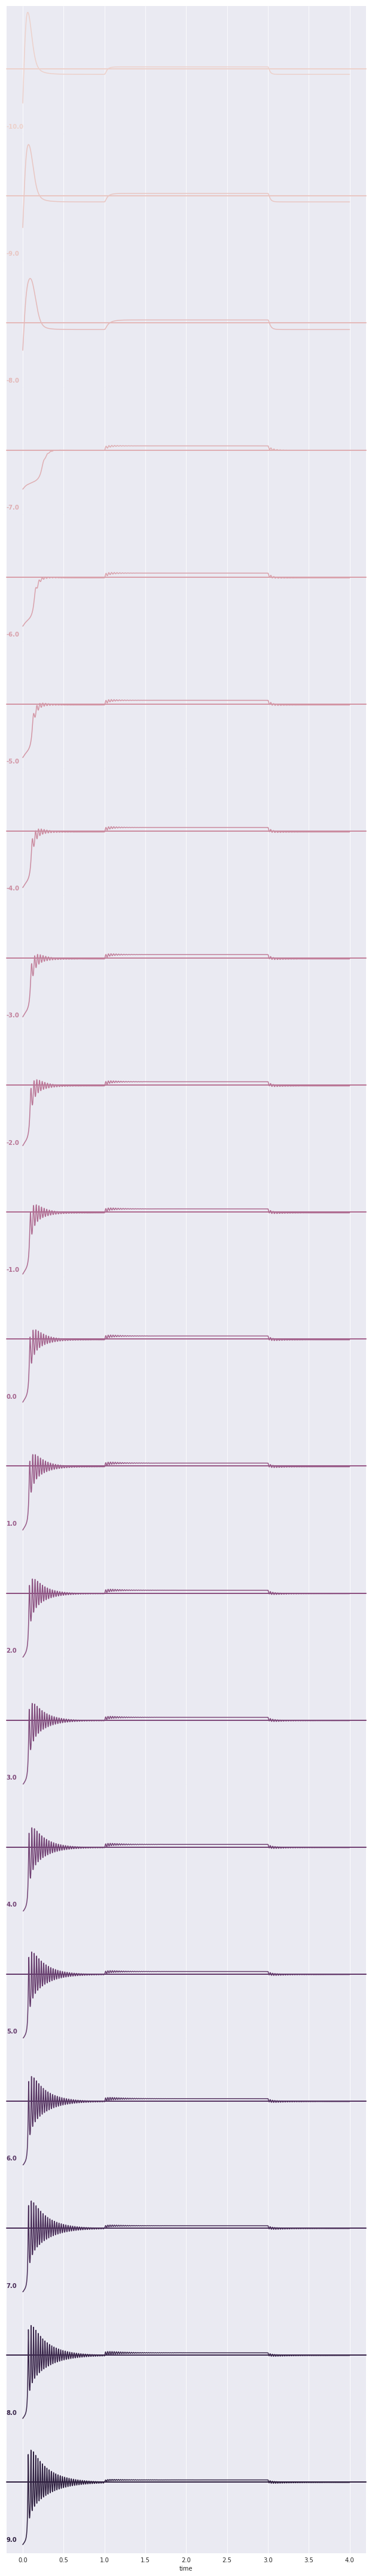

In [6]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'eta_0': eta_0}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $\alpha$**

In [7]:
# parameter definition
alpha = np.arange(0.001, 0.1, 0.005)
param_map = {'alpha': {'var': [('Op_e.0', 'alpha'), ('Op_i.0', 'alpha')],
                       'nodes': ['E.0', 'I.0']}}

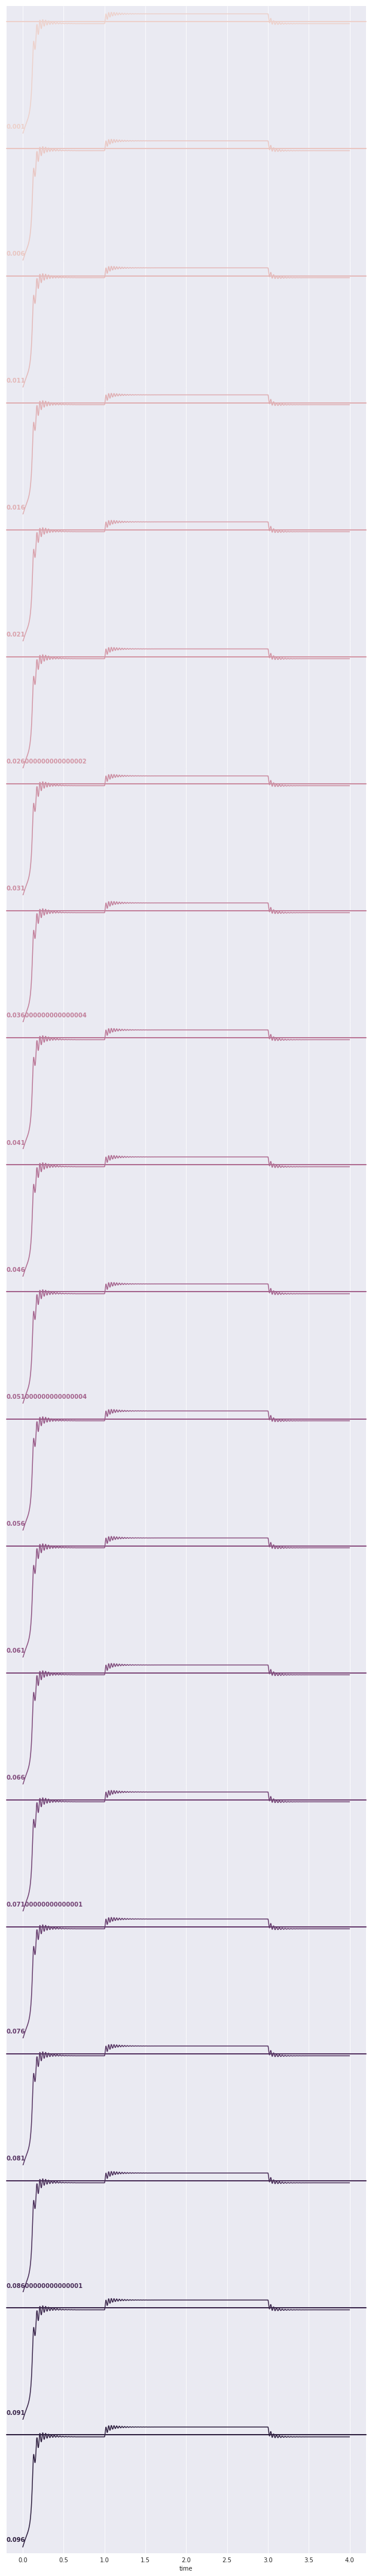

In [8]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'alpha': alpha}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $\tau_{e/i}$**

In [9]:
# parameter definition
tau = np.arange(0.001, 0.015, 0.001)
param_map = {'tau': {'var': [('Op_e.0', 'tau_e'), ('Op_i.0', 'tau_i')],
                     'nodes': ['E.0', 'I.0']}}

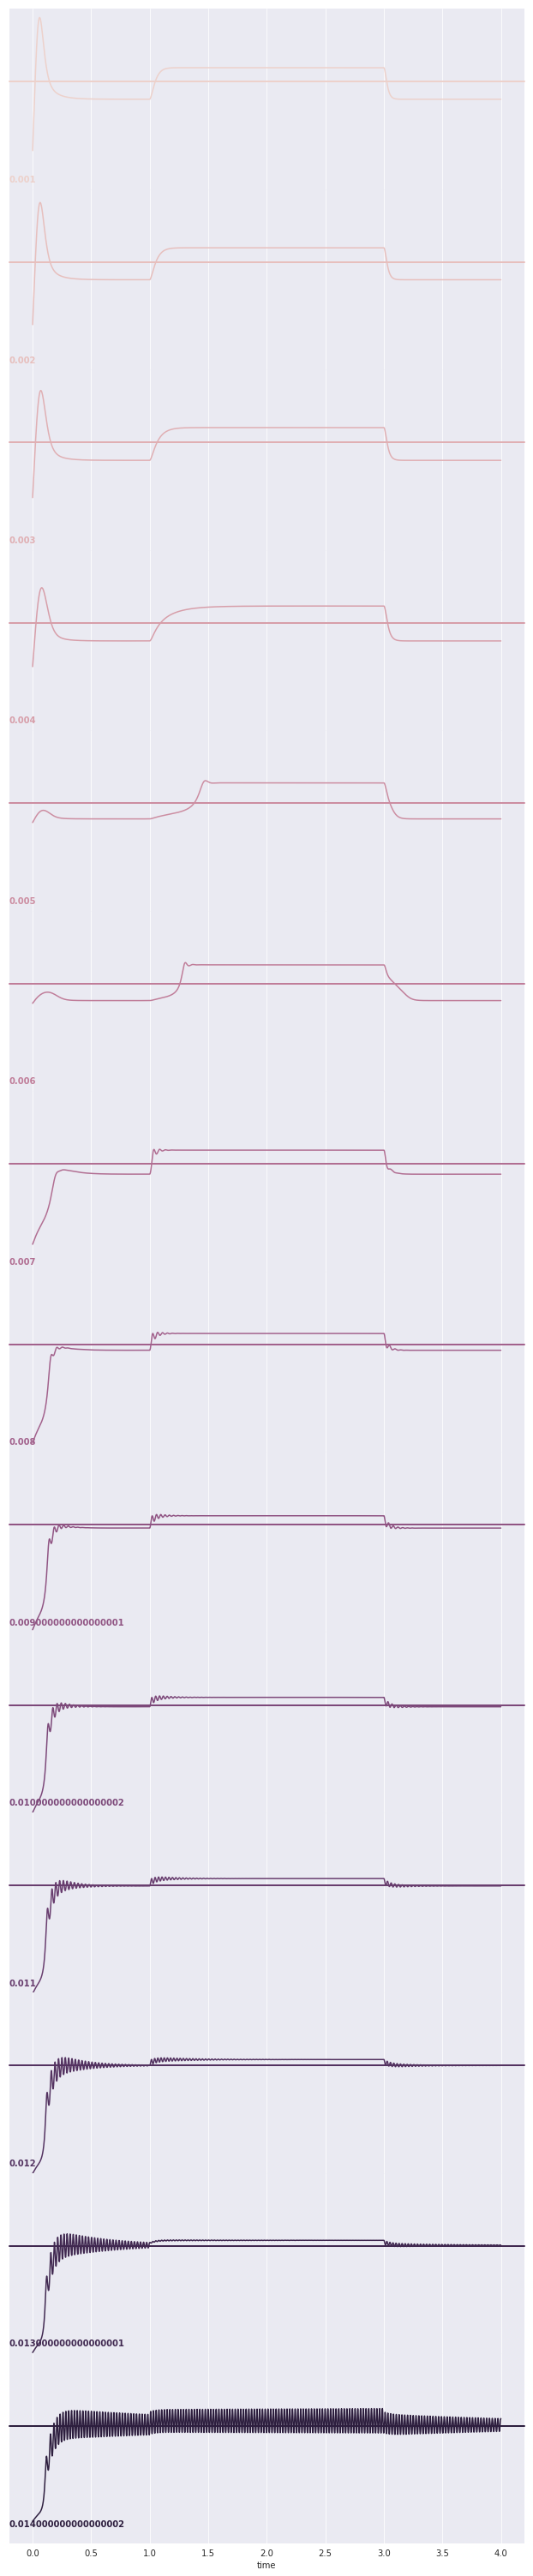

In [10]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'tau': tau}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)

**Parameter: $H_{e/i}$**

In [11]:
# parameter definition
H = np.arange(1., 16.)
param_map = {'H': {'var': [('Op_e.0', 'H_e'), ('Op_i.0', 'H_i')],
                   'nodes': ['E.0', 'I.0']}}

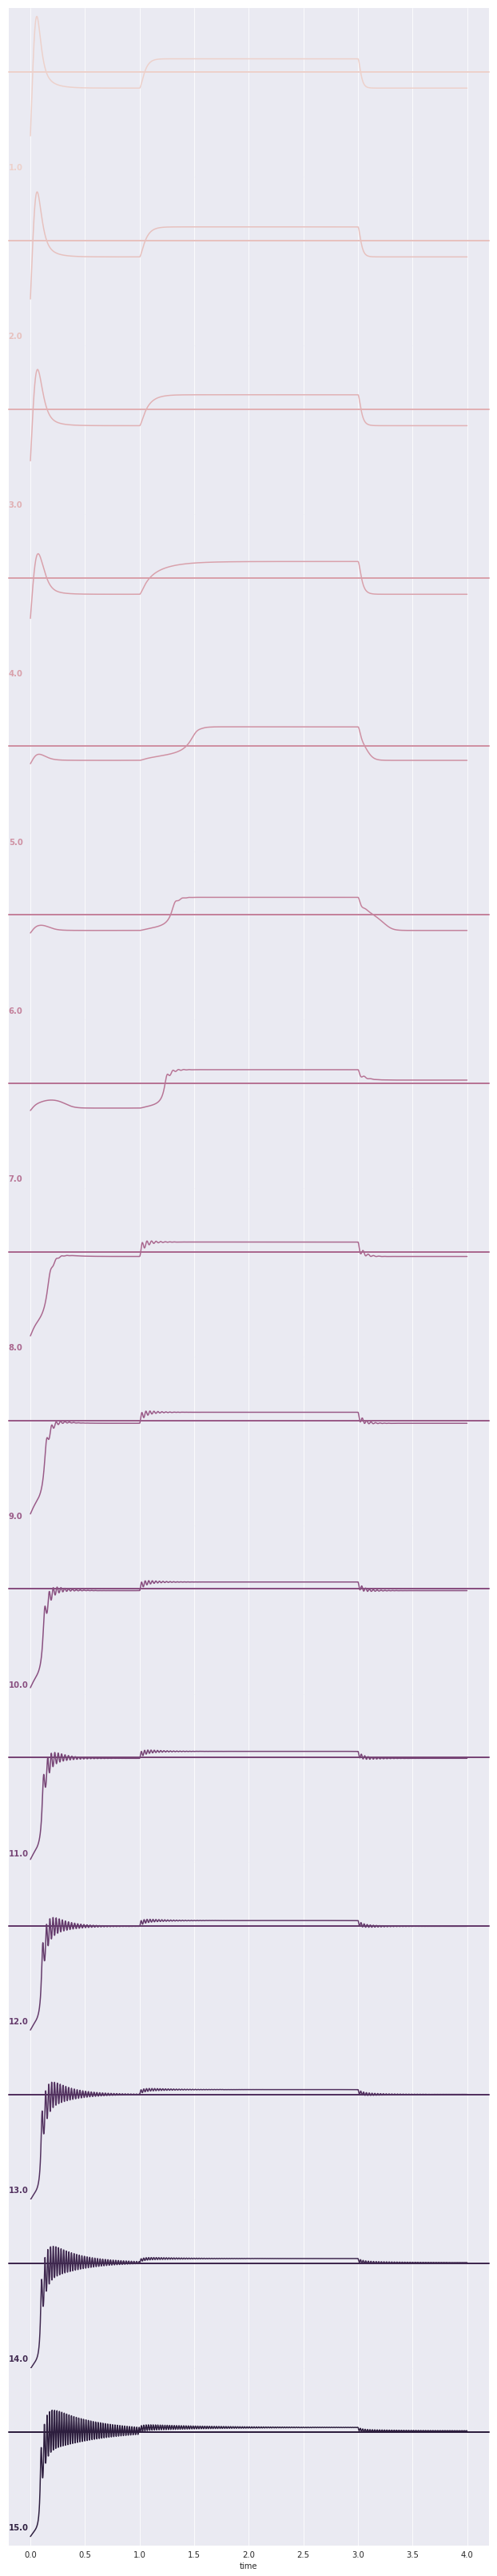

In [12]:
# simulate behavior for different deltas
results = grid_search(circuit_template="../config/cmc_templates.EI",
                      param_grid={'H': H}, param_map=param_map,
                      inputs={("E", "Op_e.0", "i_in"): input_constant, 
                              ("I", "Op_i.0", "i_in"): input_constant}, 
                      outputs={"r": ("E", "Op_e.0", "r")},
                      dt=dt, simulation_time=T, permute_grid=False, sampling_step_size=1e-3)

# plot results
plot_timeseries(results, plot_style='ridge_plot', demean=True, aspect=3.0)